# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
# SKLearn dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.metrics import classification_report_imbalanced

In [4]:
# Imbalanced dependencies
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN

# Read the CSV and Perform Basic Data Cleaning

In [5]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [6]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [7]:
# Categorical values
columns_obj=df.select_dtypes(include='object').columns

columns_obj

Index(['home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type',
       'hardship_flag', 'debt_settlement_flag'],
      dtype='object')

In [8]:
# Examine home ownership
df['home_ownership'].value_counts()

MORTGAGE    36219
RENT        24613
OWN          7346
ANY           639
Name: home_ownership, dtype: int64

In [9]:
# Examine all columns
for column in df[columns_obj]:
    print(column,"\n",df[column].value_counts())
    print("------------------------------")

home_ownership 
 MORTGAGE    36219
RENT        24613
OWN          7346
ANY           639
Name: home_ownership, dtype: int64
------------------------------
verification_status 
 Not Verified       32895
Source Verified    25737
Verified           10185
Name: verification_status, dtype: int64
------------------------------
issue_d 
 Jan-2019    31041
Feb-2019    25579
Mar-2019    12197
Name: issue_d, dtype: int64
------------------------------
loan_status 
 low_risk     68470
high_risk      347
Name: loan_status, dtype: int64
------------------------------
pymnt_plan 
 n    68817
Name: pymnt_plan, dtype: int64
------------------------------
initial_list_status 
 w    60292
f     8525
Name: initial_list_status, dtype: int64
------------------------------
next_pymnt_d 
 May-2019    42449
Apr-2019    26368
Name: next_pymnt_d, dtype: int64
------------------------------
application_type 
 Individual    59206
Joint App      9611
Name: application_type, dtype: int64
---------------------------

# Split the Data into Training and Testing

In [10]:
# Create our features
X = df.drop(columns='loan_status')


# Create our target
y = df['loan_status']

In [11]:
# Use module 17.6.4 to standard scale our X_encoded feature matrix
data_scaler=StandardScaler()

In [12]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.052138,2.219423,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.390633,1.897432,8.326426,33.631463,0.336732,0.0,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,20.000000,0.000000,0.000000,0.0,3.600000e+03,2.350000e+02,100.000000,1.270000e+02
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.000000,93.000000,0.000000,0.000000,0.0,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,2.000000,100.000000,20.000000,0.000000,0.0,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,3.000000,100.000000,50.000000,0.000000,0.0,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,18.000000,19.000000,100.000000,100.000000,4.000000,0.0,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06


In [13]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [14]:
# Use get dummies to transform object dtypes into int
X_encoded=pd.get_dummies(X)
X_encoded.shape

(68817, 95)

In [15]:
# Fit and transform our X_encoded 
X_encoded_scaled=data_scaler.fit_transform(X_encoded)

In [16]:
X_encoded.shape

(68817, 95)

In [17]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X_encoded_scaled,y,random_state= 1)

In [18]:
y_train.value_counts()

low_risk     51366
high_risk      246
Name: loan_status, dtype: int64

In [19]:
# Initiate a logistic regression model
classifier = LogisticRegression(solver='lbfgs', random_state=1)

classifier

LogisticRegression(random_state=1)

In [20]:
# Fit our model with our data (training)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [21]:
# Create predictions using predict() method

y_pred=classifier.predict(X_test)

y_pred

array(['low_risk', 'low_risk', 'low_risk', ..., 'low_risk', 'low_risk',
       'low_risk'], dtype=object)

In [22]:
# view data
pd.DataFrame({"Prediction":y_pred,'Actual':y_test})

,Prediction,Actual
7034,low_risk,low_risk
38804,low_risk,low_risk
65533,low_risk,low_risk
37736,low_risk,low_risk
6390,low_risk,low_risk
...,...,...
31854,low_risk,low_risk
27835,low_risk,low_risk
3089,low_risk,low_risk
43343,low_risk,low_risk


In [23]:
# Accuracy score
accuracy_score(y_test,y_pred)

0.995059575704737

In [24]:
# Create a confusion matrix
matrix=confusion_matrix(y_test,y_pred)

print(matrix)

[[   21    80]
 [    5 17099]]


In [25]:
# View thr classification report
report=classification_report(y_test,y_pred)

print(report)

              precision    recall  f1-score   support

   high_risk       0.81      0.21      0.33       101
    low_risk       1.00      1.00      1.00     17104

    accuracy                           1.00     17205
   macro avg       0.90      0.60      0.66     17205
weighted avg       0.99      1.00      0.99     17205



In [26]:
# view imbalanced classification report
report=classification_report_imbalanced(y_test,y_pred)

print(report)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.81      0.21      1.00      0.33      0.46      0.19       101
   low_risk       1.00      1.00      0.21      1.00      0.46      0.22     17104

avg / total       0.99      1.00      0.21      0.99      0.46      0.22     17205



# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [27]:
# Resample the training data with the RandomOversampler
ros = RandomOverSampler(random_state=1)
X_resampled,y_resampled = ros.fit_resample(X_train,y_train)

In [28]:
# Train the Logistic Regression model using the resampled data
#model
clf=LogisticRegression(solver='lbfgs',random_state=1)
#fit
clf.fit(X_resampled,y_resampled)
#predict
y_pred = clf.predict(X_test)

In [29]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8325468421491353

In [53]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
print(cm)

[[   83    18]
 [ 2285 14819]]


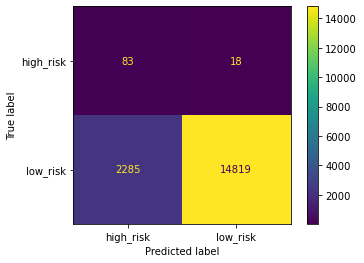

In [55]:
# Confusion Matrix using ConfusionMatrixDisplay
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

disp.plot()

# save image
plt.savefig("./Images/RandomOverSampler_confusion_matrix.png")

In [59]:
# Print the imbalanced classification report
print("RandomOverSampler Algorithm")
print(classification_report_imbalanced(y_test,y_pred))

RandomOverSampler Algorithm
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.82      0.87      0.07      0.84      0.71       101
   low_risk       1.00      0.87      0.82      0.93      0.84      0.72     17104

avg / total       0.99      0.87      0.82      0.92      0.84      0.72     17205



### SMOTE Oversampling

In [33]:
# Resample the training data with SMOTE
# YOUR CODE HERE

In [34]:
# Train the Logistic Regression model using the resampled data
X_resampled, y_resampled = SMOTE(random_state=1,
                                sampling_strategy='auto').fit_resample(
X_train,y_train)

In [35]:
#model
model=LogisticRegression(solver='lbfgs',random_state=1)
#fit
model.fit(X_resampled,y_resampled)
#predict
y_pred = model.predict(X_test)

In [36]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test,y_pred)

0.8440938486973113

In [37]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

print(cm)

[[   83    18]
 [ 2285 14819]]


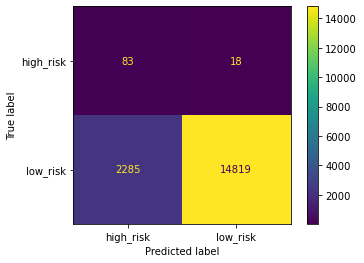

In [57]:
# ConfusionMatrixDisplay
display=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

display.plot()

# save image
plt.savefig("./Images/SMOTE_confusion_matrix.png")

In [60]:
# Print the imbalanced classification report
print("SMOTE Algorithm")
print(classification_report_imbalanced(y_test,y_pred))

SMOTE Algorithm
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.82      0.87      0.07      0.84      0.71       101
   low_risk       1.00      0.87      0.82      0.93      0.84      0.72     17104

avg / total       0.99      0.87      0.82      0.92      0.84      0.72     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [40]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
cc = ClusterCentroids(random_state=1)
X_resampled,y_resampled = cc.fit_resample(X_train,y_train)

In [41]:
# Train the Logistic Regression model using the resampled data
model=LogisticRegression(solver='lbfgs',random_state=1)
#fit
model.fit(X_resampled,y_resampled)

LogisticRegression(random_state=1)

In [42]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test,y_pred)

0.8440938486973113

In [43]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
print(cm)

[[   83    18]
 [ 2285 14819]]


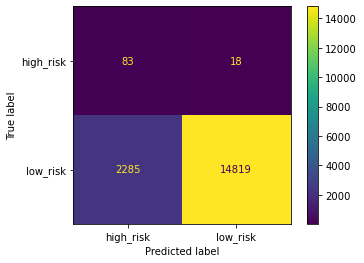

In [61]:
# ConfusionMatrixDisplay
display=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

display.plot()

# save image
plt.savefig("./Images/ClusterCentroid_confusion_matrix.png")

In [62]:
# Print the imbalanced classification report
print("ClusterCentroid Algorithm")
print(classification_report_imbalanced(y_test,y_pred))

ClusterCentroid Algorithm
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.82      0.87      0.07      0.84      0.71       101
   low_risk       1.00      0.87      0.82      0.93      0.84      0.72     17104

avg / total       0.99      0.87      0.82      0.92      0.84      0.72     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [46]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
smote_enn=SMOTEENN(random_state=0)
X_resampled,y_resampled=SMOTE(random_state=1, sampling_strategy='auto').fit_resample(X_train,y_train)

In [47]:
# Train the Logistic Regression model using the resampled data
#model
model=LogisticRegression(solver='lbfgs',random_state=1)
#fit
model.fit(X_resampled,y_resampled)
#predict
y_pred=model.predict(X_test)

In [48]:
# Calculated the balanced accuracy score
y_pred=model.predict(X_test)
balanced_accuracy_score(y_test,y_pred)

0.8440938486973113

In [49]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
print(cm)

[[   83    18]
 [ 2285 14819]]


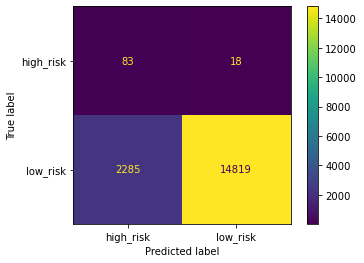

In [63]:
# ConfusionMatrixDisplay
display=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

display.plot()

# save image
plt.savefig("./Images/SMOTEENN_confusion_matrix.png")

In [65]:
# Print the imbalanced classification report
print("SMOTEENN Algorithm")
print(classification_report_imbalanced(y_test,y_pred))

SMOTEENN Algorithm
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.82      0.87      0.07      0.84      0.71       101
   low_risk       1.00      0.87      0.82      0.93      0.84      0.72     17104

avg / total       0.99      0.87      0.82      0.92      0.84      0.72     17205

